## Setup

For these examples, you'll need:

1. qiskit, version >=1.0 and <2.0
2. qiskit-ionq
3. An IonQ API key

If this notebook was not launched from an environment where Qiskit and Qiskit-IonQ are installed, uncomment and run the next cell to install them in this notebook's kernel.

In [ ]:
#%pip install "qiskit==1.4" qiskit-ionq

You can generate an API key from the [IonQ Cloud Console](https://cloud.ionq.com/settings/keys).

We generally recommend storing your API key as an environment variable, rather than including it in your code. However, for today's workshop we'll set it here:

!echo $IONQ_API_KEY

## 1. Qiskit + IonQ Quantum Cloud simulator

We'll build a simple "hello world" Bell state circuit using Qiskit, then run it on IonQ's cloud simulator.

See also: our [guide](https://docs.ionq.com/sdks/qiskit) to getting started with Qiskit and IonQ backends.

First, we'll set up the `IonQProvider`, which manages the connection to IonQ's systems.

In [2]:
from qiskit.visualization import plot_histogram
from qiskit_ionq import IonQProvider
provider = IonQProvider()

/opt/venv/lib/python3.12/site-packages/qiskit_ionq/ionq_backend.py:127: IonQTranspileLevelWarning: Transpiler default optimization_level=2. IonQ (QIS) recommends 0-1 to avoid aggressive re-synthesis; use transpile(..., optimization_level=1).
  warn_bad_transpile_level()


This setup assumes that your environment variable is named `IONQ_API_KEY`, which enables qiskit-ionq to automatically find your API key. You can also pass the key into the provider directly.

If you set up your API key as an environment variable with a different name (for example, if you are running jobs in multiple organizations or projects from the same environment), you can load that environment variable:
```
provider = IonQProvider(token=os.environ.get("IONQ_API_KEY_QCUF"))
```

If you didn't set up your API key as an environment variable, you can paste it in directly (but be careful sharing or storing your code):
```
provider = IonQProvider(token="abc123-xxx-yyy-zzz")
```

### Ideal simulation

Once we have the provider, we'll use it to retrieve a backend, starting with IonQ's cloud simulator. The ideal simulator (with no noise model selected) goes up to 29 qubits.

In [3]:
backend_sim = provider.get_backend("simulator")

In general, this backend can be used in the same way as other backends in Qiskit (<2.0). Here, we'll construct a circuit directly and run it on the simulator backend:

In [4]:
from qiskit import QuantumCircuit

# Create a basic Bell State circuit:
qc_bell = QuantumCircuit(2, name="Ideal sim example")
qc_bell.h(0)
qc_bell.cx(0, 1)
qc_bell.measure_all()

qc_bell.draw()

┌───┐      ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
meas: 2/══════════════╩══╩═
                      0  1

Next, run the circuit on the ideal simulator backend. Although we can specify a number of shots, the ideal simulator performs a single statevector simulation and stores all of the probabilities. The number of shots specified here can be used for sampling from those probabilities when retrieving results.

In [5]:
job_sim = backend_sim.run(
    qc_bell,
    shots=1000
)
job_sim.status()

If you got an `IonQAPIError` that says "405: Insufficient Scope", the provider didn't find your API key, or it found an invalid key.

We can check the job status here (or [on the "My Jobs" page of the IonQ Cloud Console](https://cloud.ionq.com/jobs/)). Since this is a small simulator job, it should complete quickly:

<JobStatus.DONE: 'job has successfully run'>

For the ideal simulation, the result of the calculation is the probabilities:

In [8]:
job_sim.get_probabilities()

{'00': 0.5, '11': 0.5}

We can also look at the counts. These counts are based on sampling the specified number of shots from the stored probabilities, so they'll be different each time this command is run.

In [ ]:
job_sim.get_counts()

Visualizing the counts (or probabilities):

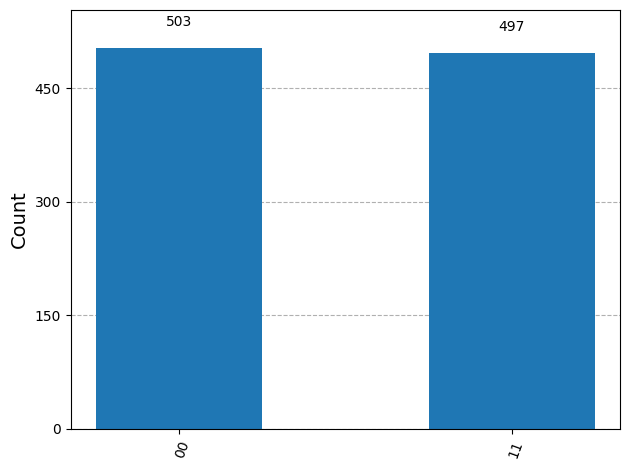

In [18]:
plot_histogram(job_sim.get_counts())

The circuit visualization, histogram, and other job info can also be found in the [IonQ Cloud Console](https://cloud.ionq.com/jobs/).

### Retrieving a job from its ID

If we need to access a job's results later, we can use the job's unique identifier. As soon as a job is submitted, it is assigned a job ID, which you can get via the `.job_id()` method or from the cloud console.

In [ ]:
print(job_sim.job_id())

To retrieve a job, just set up a backend (with the same backend type and settings used to create the job) and call `.retrieve_job()`:

In [ ]:
job_sim_retrieved = backend_sim.retrieve_job("YOUR JOB ID HERE")

Then we can get the result:

In [ ]:
job_sim_retrieved.get_probabilities()

### Multicircuit jobs

We can also submit a set of multiple circuits (all using the same backend and settings). Each circuit is still executed independently, but they can be grouped together to help organize workflows or streamline code.

Here, we'll set up a helper function to build example circuits with different numbers of qubits:

In [ ]:
def create_ghz_circuit(n):
    qc = QuantumCircuit(n, name=f"{n}-qubit circuit")
    qc.h(0)
    for i in range(1, n):
        qc.cx(0, i)
    qc.measure_all()
    return qc

In [ ]:
qc_ghz2 = create_ghz_circuit(2)
qc_ghz2.draw()

In [ ]:
qc_ghz3 = create_ghz_circuit(3)
qc_ghz3.draw()

In [ ]:
qc_ghz4 = create_ghz_circuit(4)
qc_ghz4.draw()

To submit these circuits as one multicircuit job, we just provide a list of circuits to the backend:

In [ ]:
job_multicirc = backend_sim.run(
    [qc_ghz2, qc_ghz3, qc_ghz4],
    shots=1000
)

On the ["My Jobs" page](https://cloud.ionq.com/jobs), this job will show as a multicircuit job with 3 circuits.

Retrieving the parent job counts will give the results for all 3 circuits:

In [ ]:
job_multicirc.get_probabilities()

In [ ]:
job_multicirc.get_counts()

We can also retrieve the counts for a specific circuit:

In [ ]:
job_multicirc.get_counts(qc_ghz3)

A multicircuit job has a parent job ID, and each child job also has its own job ID, accessible via the cloud console.

In [ ]:
job_child1 = backend_sim.retrieve_job("YOUR JOB ID HERE")

Submitting a set of individual circuits as a multicircuit job doesn't change how they are executed, but it can be convenient for structuring your code and organizing your jobs.

There's no specific limit on the number of child circuits that can be included in a multicircuit submission - just the overall size of the job request being sent to our systems. Note that Qiskit retrieves all child job results when you request the counts for a parent job, which can take a long time or even time out if there are many large histograms to download. However, you can always retrieve each child job's result individually.

### Noisy simulation

Our cloud simulator can also be used with [noise models based on our QPUs](https://docs.ionq.com/guides/simulation-with-noise-models). Currently, each of these is implemented as a simple depolarizing model with parameters set based on hardware characterization, but more complex models may be available in the future.

To use a noise model, set the simulator backend options:

In [9]:
backend_sim_forte = provider.get_backend("simulator")
backend_sim_forte.set_options(noise_model="forte-1")

Optionally, you can also specify a random seed to get reproducible results:
```
backend_sim_forte.set_options(noise_model="forte-1", seed=12345)
```

The circuit setup is the same as before (we'll change the name here):

In [10]:
qc_bell = QuantumCircuit(2, name="Sim example with noise")
qc_bell.h(0)
qc_bell.cx(0, 1)
qc_bell.measure_all()

We'll submit to the simulator backend with noise model. This time, the number of shots determines the number of times the simulation is run. The default is 1024.

In [11]:
job_noisy = backend_sim_forte.run(qc_bell, shots=1000)

As before, we can check the job status here or in the cloud console
If you got an IonQAPIError that says "405: Insufficient Scope", the provider didn't find your API key, or it found an invalid key.

We can check the job status here (or on the "My Jobs" page of the IonQ Cloud Console). 

In [13]:
job_noisy.status()

<JobStatus.DONE: 'job has successfully run'>

And we can get the counts from the job:

In [14]:
job_noisy.get_counts()

{'00': 495, '01': 3, '10': 2, '11': 500}

In [28]:
job_noisy.job_id()

'019a08d9-841e-762b-a133-83005cde6493'

In this case, there were some shots where the "measured" result of the simulation was 01 or 10 due to an error.

We can also compare results for different noise models - we expect Aria-class systems to have more noise and higher error rates relative to Forte-class systems, and this is reflected in the noise models. These noise models are approximate and can't tell you specifically whether a circuit will give a good result on any specific system, but they can be used to understand the general effect of noise and qualitative trends.

In [20]:
backend_sim_aria = provider.get_backend("simulator")
backend_sim_aria.set_options(noise_model="aria-1")

/opt/venv/lib/python3.12/site-packages/qiskit_ionq/ionq_backend.py:127: IonQTranspileLevelWarning: Transpiler default optimization_level=2. IonQ (QIS) recommends 0-1 to avoid aggressive re-synthesis; use transpile(..., optimization_level=1).
  warn_bad_transpile_level()


In [21]:
job_noisy2 = backend_sim_aria.run(qc_bell, shots=1000)

In [22]:
job_noisy2.get_counts()

{'00': 530, '01': 3, '10': 2, '11': 465}

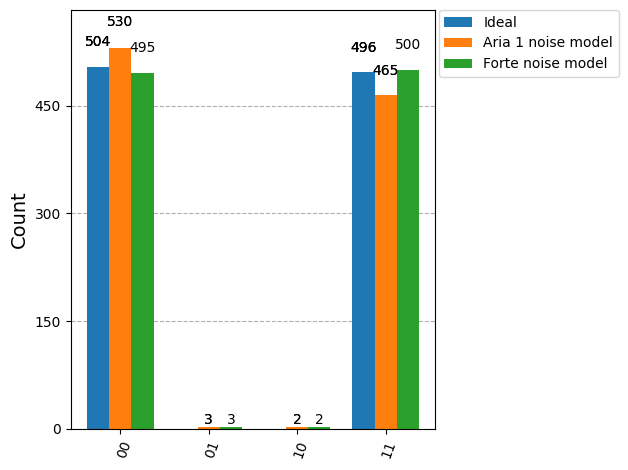

In [23]:
plot_histogram(
    [job_sim.get_counts(), job_noisy2.get_counts(), job_noisy.get_counts()],
    legend=["Ideal", "Aria 1 noise model", "Forte noise model"]
)

### Additional settings

You can pass in custom metadata or other API-supported arguments via `extra_query_params`.

Here we'll use the same Bell state circuit as before, but we'll change the name (since the job name is derived from the Qiskit circuit name).

In [ ]:
qc_bell.name = "Custom metadata example"

backend_sim.run(
    qc_bell,
    shots=1000,
    extra_query_params={'metadata': {'event': 'QCUF 2025'}}
)

Custom metadata fields are shown on the job detail page in the cloud console and can be used to organize and filter jobs (in the "my jobs" table or in your code).

## 2. Qiskit + IonQ QPU

Running a circuit on IonQ hardware is very similar to running on our cloud simulators - just select a QPU backend. Depending on your access, options might include `qpu.aria-1`, `qpu.aria-2`, `qpu.forte-1`, `qpu.forte-enterprise-1`, or other future systems.

In [15]:
backend_aria = provider.get_backend("qpu.aria-1")

In [ ]:
qc_bell = QuantumCircuit(2, name="Aria 1 example")
qc_bell.h(0)
qc_bell.cx(0, 1)
qc_bell.measure_all()

In [ ]:
job_aria = backend_aria.run(qc_bell, shots=100)

In this case, the job may not run right away, and it will likely take longer to run on the QPU than on the simulator.

We can check the job status to verify that the submission was accepted (if there's an issue with the circuit, or you don't have the right permissions or budget, it should fail right away).

In [ ]:
job_aria.status()

The job status will show as "queued" here, or "ready" in the cloud console, if the job has been accepted and is waiting for a system to be available.

(Switch to slides)

Check back later:

In [ ]:
job_aria.status()

In [ ]:
job_aria.get_counts()